# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 2. Классификация при помощи CNN. 

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [ ]:
import matplotlib.pyplot as plt
import wandb
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [ ]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

Посмотрим на изображения:

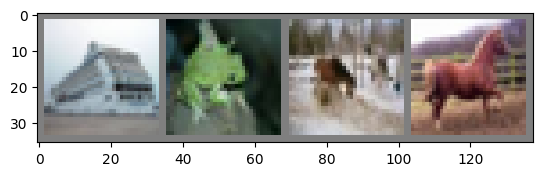

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Первый слой
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, bias=False, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        
        # Второй слой
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, bias=False, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Shortcut
        self.shortcut = nn.Sequential(nn.Conv2d(3, 32, kernel_size=1, stride=1, bias=False))

        # Average Pooling (4x4)
        # kernel_size=8 для входа 32x32 -> выхода 4x4
        self.pool = nn.AvgPool2d(kernel_size=8)

        # Линейный слой после пулинга
        self.fc = nn.Linear(in_features=32*4*4, out_features=n_classes)


    def forward(self, x):
        identity = x # Для shortcut

        # 1 Слой
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 2 Слой
        out = self.conv2(out)
        out = self.bn2(out)

        # Shortcut, сложениие 
        shortcut_out = self.shortcut(identity)
        out += shortcut_out

        # ReLU и Pooling
        out = self.relu(out)
        out = self.pool(out)

        # Распрямление в вектор (512x1)
        out = torch.flatten(out, 1)
        
        # Финальный линейный слой
        out = self.fc(out)

        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [ ]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = nn.CrossEntropyLoss()

    for data, target in loader:
        data, target = data.to(device), target.to(device)

        # forward
        y_pred = model(data)
        loss = criterion(y_pred, target)
        loss_log.append(loss.item())

        # accuracy
        pred_classes = y_pred.argmax(dim=-1)
        acc = (pred_classes==target).float().mean()
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # zero gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = model(data)
        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()
    
        # accuracy
        pred_classes = y_pred.argmax(dim=-1)
        acc = (pred_classes==target).float().mean()

        loss_log.append(loss.item())
        acc_log.append(acc.item())

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        # Логирование метрик по эпохам
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": np.mean(train_loss),
            "train_accuracy": np.mean(train_acc),
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "learning_rate": optimizer.param_groups[0]['lr']
        })

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        # Небольшая модификация, чтобы ReduceLROnPlateau заработал
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.4630173440389267, train acc: 0.48063299817184646
 val loss: 1.222879353989946, val acc: 0.5693927305809995

Epoch 1
 train loss: 1.1496903250160775, train acc: 0.5992018151108918
 val loss: 1.0583167875066717, val acc: 0.6284796099713508

Epoch 2
 train loss: 1.0316870319342046, train acc: 0.6396415513655821
 val loss: 1.0251429151981435, val acc: 0.6376994680851064

Epoch 3
 train loss: 0.984104321796236, train acc: 0.6576496800731262
 val loss: 0.9738151740520559, val acc: 0.6666888297872341

Epoch 4
 train loss: 0.9465742383622164, train acc: 0.6734950379000285
 val loss: 0.9596681447739297, val acc: 0.6630984042553192

Epoch 5
 train loss: 0.9169915112542496, train acc: 0.6833907352722977
 val loss: 1.026805830001831, val acc: 0.6485815603682336

Epoch 6
 train loss: 0.900769990802465, train acc: 0.6859778989603577
 val loss: 1.0144137144088745, val acc: 0.6555186170212766

Epoch 7
 train loss: 0.8799717176766892, train acc: 0.6945351267427587
 val loss: 0.91

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test accuracy: {test_acc}")

test loss: 0.8961443559379335, test accuracy: 0.6960589171974523


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

`Выводы`
* По эпохам обучения можем наблюдать стабильное снижение лосса и увеличение точности предсказаний
* Точность на обучающей выборке - 0.742, на валидации - 0.704, на тестовой выборке - 0.696, неплохой результат, но наблюдается переобучение модели (видим разрыв между метриками на выборках)

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [ ]:
# Функция для построения графиков
def plot_history(train_history, val_history, title="loss", ax=None):
    ax.set_title(title)
    ax.plot(train_history, label="train", zorder=1)

    steps = list(
        range(0, len(train_history) + 1, int(len(train_history) / len(val_history)))
    )[1:]

    ax.scatter(
        steps, val_history, linestyle="-", linewidth=1, c="orange", label="val", zorder=2
    )
    ax.set_xlabel("train steps")

    ax.legend(loc="best")
    ax.grid()

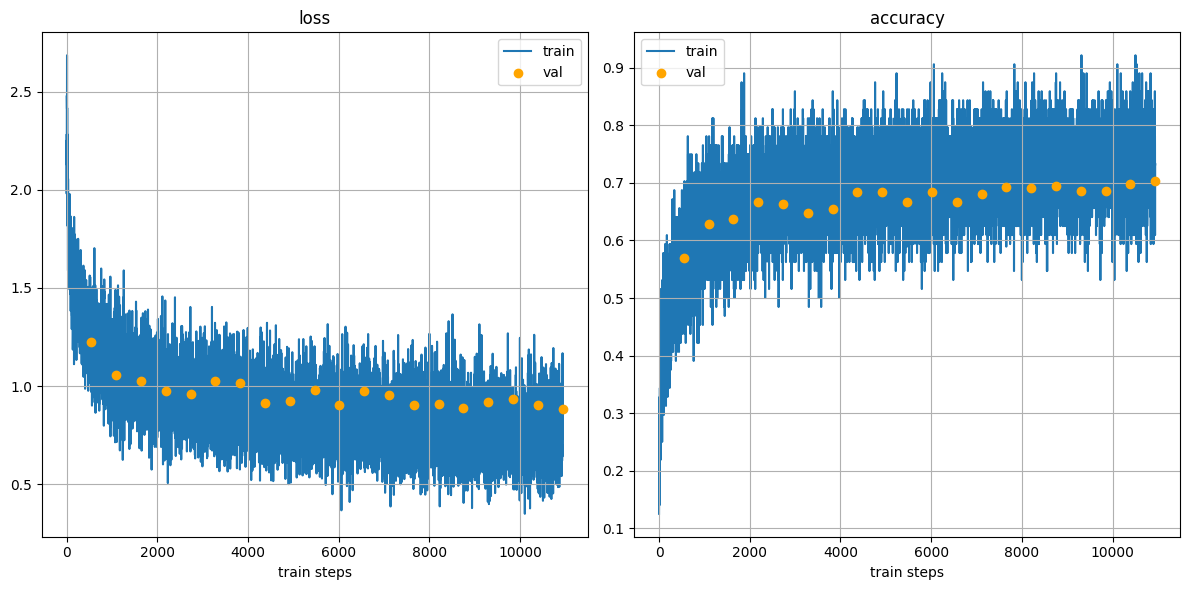

In [ ]:
# Визуализируем
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plot_history(train_loss_log, val_loss_log, "loss", ax1)
plot_history(train_acc_log, val_acc_log, "accuracy", ax2)

plt.tight_layout()
plt.show()

`Выводы`
* С течением времени loss на обучающей и валидационной выборках уменьшается, accuracy растёт (как и должно быть)
* Учитывая разрыв между графиками валидации и обучения, можно сделать вывод о переобучении сети (что мы также подтвердили по метрикам точности в прошлом пункте)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4627582919009208, train acc: 0.4782253852492059
 val loss: 1.281145076041526, val acc: 0.5482047872340425

Epoch 1
 train loss: 1.1582958749486933, train acc: 0.5951986485033193
 val loss: 1.1777869658267244, val acc: 0.5977171986661058

Epoch 2
 train loss: 1.0440096739659144, train acc: 0.6380623205270366
 val loss: 1.1605772114814596, val acc: 0.5960328015875309

Epoch 3
 train loss: 0.988529433497999, train acc: 0.6563397754916761
 val loss: 1.0106505064254112, val acc: 0.647628546268382

Epoch 4
 train loss: 0.9495296642810814, train acc: 0.6699489096836808
 val loss: 0.9422566099369779, val acc: 0.6737810284533399

Epoch 5
 train loss: 0.9206098360596888, train acc: 0.6809586381345606
 val loss: 0.9458518127177624, val acc: 0.6738918441407225

Epoch 6
 train loss: 0.8978675586431946, train acc: 0.6872551580669675
 val loss: 0.9799158720259971, val acc: 0.6651595744680852

Epoch 7
 train loss: 0.8770586428738163, train acc: 0.6961551646427873
 val loss: 0.91

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test accuracy: {test_acc}")

test loss: 0.8384727520547854, test accuracy: 0.7116839171974523


`Выводы`
* Если сравнивать с прошлым решением, то мы получаем небольшое повышение общей точности (~1.5-2%) для каждой из выборок

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.801336943122543, train acc: 0.37064181254594375
 val loss: 1.578994492774314, val acc: 0.4516622340425532

Epoch 1
 train loss: 1.5067746392987547, train acc: 0.46909277879341865
 val loss: 1.4284316382509596, val acc: 0.5025265957446808

Epoch 2
 train loss: 1.3967475106554885, train acc: 0.5091489293021737
 val loss: 1.343042268651597, val acc: 0.5330452127659574

Epoch 3
 train loss: 1.3299031968090609, train acc: 0.5346043353978633
 val loss: 1.3134016589915498, val acc: 0.5384751773895101

Epoch 4
 train loss: 1.2725072565200777, train acc: 0.5555587294332724
 val loss: 1.2460735473226994, val acc: 0.5630097518575953

Epoch 5
 train loss: 1.2279081818608524, train acc: 0.5676171977951496
 val loss: 1.2021941611107358, val acc: 0.5811170212765957

Epoch 6
 train loss: 1.1881947033584008, train acc: 0.5844378427787934
 val loss: 1.2201367208298217, val acc: 0.5713874114320633

Epoch 7
 train loss: 1.154403516535785, train acc: 0.5992058957952467
 val loss: 1.1

In [ ]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test accuracy: {test_acc}")

test loss: 0.9543691877346889, test accuracy: 0.6712778662420382


`Выводы`
* Действительно, получаем самое плохое качество из всех экспериментов - test accuracy (0.671), в сравнении с чистым SGD (0.696) и SGD + MultiStepLR (0.711)
* Снижение точности может быть связано с застреванием в локальных минимумах (низкий learning rate не даёт оттуда выбираться), тогда как в случае с MultiStepLR мы быстро сходились к оптимуму с высоким learning rate, а затем уменьшали его, более точно подстраивать веса

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

`В качестве дополнительных планировщиков (lr_scheduler) протестируем ReduceLROnPlateau (уменьшает lr, если validation loss перестал улучшаться в течение заданного числа эпох (patience=3 в нашем случае), уменьшение происходит путем умножения lr на factor (0.1 в нашем случае)) и CosineAnnealingLR (изменяет lr по косинусу в пределах заданного числа эпох (T_max=10 в нашем случае), lr начинается с максимума, уменьшается до минимума, следуя косинусной функции)`

In [ ]:
# ReduceLROnPlateau
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4611760996813312, train acc: 0.47822130456485085
 val loss: 1.2777619658632482, val acc: 0.5488696808510638

Epoch 1
 train loss: 1.157735820662169, train acc: 0.594810982073029
 val loss: 1.147703908098505, val acc: 0.5979609929500742

Epoch 2
 train loss: 1.046408590603572, train acc: 0.6377440259487145
 val loss: 1.178311268319475, val acc: 0.590314716481148

Epoch 3
 train loss: 0.9889754414340478, train acc: 0.6575068555758684
 val loss: 1.0055191975958804, val acc: 0.6506205675449778

Epoch 4
 train loss: 0.9493921858954909, train acc: 0.6712914599579038
 val loss: 0.9453206351462831, val acc: 0.6725620569066798

Epoch 5
 train loss: 0.921369020420193, train acc: 0.6789631758573068
 val loss: 0.9399495309971748, val acc: 0.6736702127659574

Epoch 6
 train loss: 0.9011653257462399, train acc: 0.6848230609292304
 val loss: 0.978855340277895, val acc: 0.6634530142266699

Epoch 7
 train loss: 0.8791845255621609, train acc: 0.6959266454471749
 val loss: 0.938684

In [ ]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test accuracy: {test_acc}")

test loss: 0.9105066239454185, test accuracy: 0.6832205414012739


In [ ]:
# CosineAnnealingLR 
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4926678559026072, train acc: 0.47024353624915727
 val loss: 1.2391971288843358, val acc: 0.5671320922831271

Epoch 1
 train loss: 1.1863067013907913, train acc: 0.5840338535021167
 val loss: 1.13624350999264, val acc: 0.6002881207364671

Epoch 2
 train loss: 1.0691944110110212, train acc: 0.6256855576958037
 val loss: 1.0444597401517504, val acc: 0.6376329787234043

Epoch 3
 train loss: 0.9925641008879192, train acc: 0.655976593167516
 val loss: 0.9984168093255226, val acc: 0.6557402483960415

Epoch 4
 train loss: 0.931428866151046, train acc: 0.6775145273539877
 val loss: 1.0927237386399127, val acc: 0.6246010638297872

Epoch 5
 train loss: 0.8826115743224756, train acc: 0.6945432881114688
 val loss: 0.9327439630285222, val acc: 0.6751773050490846

Epoch 6
 train loss: 0.8439794436124387, train acc: 0.7095276182704695
 val loss: 0.9107139059837829, val acc: 0.6869902483960415

Epoch 7
 train loss: 0.809690138812039, train acc: 0.7221818687275079
 val loss: 0.865

In [ ]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test accuracy: {test_acc}")

test loss: 0.9156776093373633, test accuracy: 0.6857085987261147


`Выводы`
* Из трёх вариантов lr_scheduler лучшим оказался исходный MultiStepLR, с метрикой accuracy на тесте - 0.711, на втором месте CosineAnnealingLR - 0.685, незначительно хуже себя показал ReduceLROnPlateau - 0.683, 

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

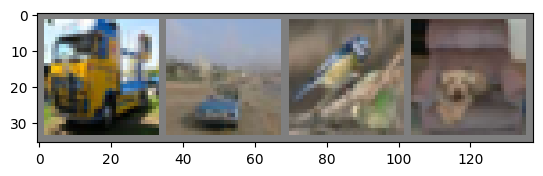

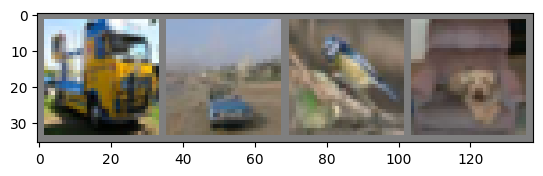

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4930579808338034, train acc: 0.4662689345410363
 val loss: 1.2886617087303325, val acc: 0.5438608156873824

Epoch 1
 train loss: 1.203512008599869, train acc: 0.5783167929274509
 val loss: 1.238563848809993, val acc: 0.5723847518575952

Epoch 2
 train loss: 1.0786599633462686, train acc: 0.6242573126142597
 val loss: 1.112558977401003, val acc: 0.6026152483960415

Epoch 3
 train loss: 1.0293406519419097, train acc: 0.6433631496629941
 val loss: 0.980648868388318, val acc: 0.6591755319148936

Epoch 4
 train loss: 0.9835419449989277, train acc: 0.6603715069987003
 val loss: 1.0103187327689314, val acc: 0.648160461161999

Epoch 5
 train loss: 0.9516159364684627, train acc: 0.6701121377116801
 val loss: 0.9818985477406927, val acc: 0.6656028369639783

Epoch 6
 train loss: 0.9230756091134422, train acc: 0.6797466701955638
 val loss: 0.9697488082216141, val acc: 0.6734485816448292

Epoch 7
 train loss: 0.9131667997545037, train acc: 0.6833213633113631
 val loss: 0.9820

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test accuracy: {test_acc}")

test loss: 0.8073904626308732, test accuracy: 0.7205414012738853


`Выводы`
* После аугментации картинок (RandomHorizontalFlip) получаем увеличение точности ~ на 1% (с 0.711 до 0.720)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

`Применим ещё 2 метода аугментации данных - RandomCrop (случайно вырезает участок изображения с заданным размером и отступом) и ColorJitter (случайно меняет яркость, контрастность, насыщенность и оттенок), затем попробуем объединить все 3 метода (включая RandomHorizontalFlip) и посмотрим на результат`

In [ ]:
# RandomCrop
transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),  # Вырезаем 32x32 с отступом 4 пикселя
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.6506568452775805, train acc: 0.3976886916422103
 val loss: 1.4556968699110315, val acc: 0.46999113483631866

Epoch 1
 train loss: 1.387560404523853, train acc: 0.5045867067586352
 val loss: 1.3246078503892778, val acc: 0.5311170212765958

Epoch 2
 train loss: 1.25492687776712, train acc: 0.5545344738463379
 val loss: 1.261760776854576, val acc: 0.5549423759287976

Epoch 3
 train loss: 1.1992816137221438, train acc: 0.5756194503259398
 val loss: 1.1772917818515858, val acc: 0.5862145390916378

Epoch 4
 train loss: 1.1570519719960703, train acc: 0.5947293680590293
 val loss: 1.228312221232881, val acc: 0.56875

Epoch 5
 train loss: 1.1127400850465137, train acc: 0.6103625294277394
 val loss: 1.1504321184564144, val acc: 0.6064937944107868

Epoch 6
 train loss: 1.090901503833164, train acc: 0.6161856882315013
 val loss: 1.147634659168568, val acc: 0.5990913120990103

Epoch 7
 train loss: 1.069038746779754, train acc: 0.6244695090724519
 val loss: 1.0752386808395387,

In [ ]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test accuracy: {test_acc}")

test loss: 0.8415904728470335, test accuracy: 0.7054140127388535


In [ ]:
# ColorJitter
transform = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.6416772309779248, train acc: 0.4143175438073697
 val loss: 1.417573742156333, val acc: 0.50815602845334

Epoch 1
 train loss: 1.324471006554703, train acc: 0.5385789371059844
 val loss: 1.3580213425007273, val acc: 0.5189716312479465

Epoch 2
 train loss: 1.215978496362348, train acc: 0.5777944633686128
 val loss: 1.219233287395315, val acc: 0.5832446808510638

Epoch 3
 train loss: 1.1636596874519503, train acc: 0.5997649517312128
 val loss: 1.184168419178496, val acc: 0.5883643617021277

Epoch 4
 train loss: 1.1224852342710199, train acc: 0.6148635414880198
 val loss: 1.166321683690903, val acc: 0.5939937944107867

Epoch 5
 train loss: 1.0884675843406204, train acc: 0.6271994973667361
 val loss: 1.1147847708235397, val acc: 0.6215868795171697

Epoch 6
 train loss: 1.0596481293603315, train acc: 0.6374461347921675
 val loss: 1.0947765127141424, val acc: 0.6279255319148936

Epoch 7
 train loss: 1.0437015916137415, train acc: 0.6421715853637053
 val loss: 1.1108912

In [ ]:
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test accuracy: {test_acc}")

test loss: 0.8834834170948928, test accuracy: 0.6959593949044586


In [ ]:
# Compose из всех методов
transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.820765884964296, train acc: 0.3391347284508798
 val loss: 1.6370175863834138, val acc: 0.4052526595744681

Epoch 1
 train loss: 1.585632682936283, train acc: 0.4270166819012797
 val loss: 1.537643135354874, val acc: 0.4518173759287976

Epoch 2
 train loss: 1.4440605566314195, train acc: 0.4890637243033763
 val loss: 1.38999760658183, val acc: 0.5126773050490846

Epoch 3
 train loss: 1.3602988612063407, train acc: 0.520876860814731
 val loss: 1.308832572876139, val acc: 0.5392508865670955

Epoch 4
 train loss: 1.3164540884481706, train acc: 0.5394562876202724
 val loss: 1.2918165201836445, val acc: 0.5412677305809995

Epoch 5
 train loss: 1.2667228134938089, train acc: 0.5570359428360432
 val loss: 1.3400181747497397, val acc: 0.5422872340425532

Epoch 6
 train loss: 1.2511198643792483, train acc: 0.5630019261370629
 val loss: 1.231126503234214, val acc: 0.5714982269926274

Epoch 7
 train loss: 1.227277174946159, train acc: 0.5742973034734917
 val loss: 1.26880310

In [ ]:
# Обучение в полтора раза дольше
test_loss, test_acc = test(net, test_loader)
print(f"test loss: {test_loss}, test accuracy: {test_acc}")

test loss: 0.9219723157821946, test accuracy: 0.6840167197452229


`Выводы`
* Лучшим из методов аугментации показал себя RandomHorizontalFlip (test accuracy 0.720), остальные эксперименты показали себя хуже, причём даже хуже результатов без аугментации (test accuracy 0.711), тогда как после аугментации RandomCrop (0.705), ColorJitter (0.696) и Compose из 3-х методов (0.684)

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

In [ ]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\dimas\_netrc
wandb: Currently logged in as: dimasix-100 (dimasix-100-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Инициализация проекта
config = {
    "learning_rate": 0.1,
    "momentum": 0.9,
    "epochs": 20,
    "batch_size": 64,
    "scheduler": None,
    "model": "BasicBlockNet",
    "dataset": "CIFAR-10"
}

wandb.init(project="pytorch-hw2", config=config, name="net-hw2")
wandb.watch(net)

# Train + val
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

# Test + wandb log
test_loss, test_acc = test(net, test_loader)
wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

# Завершение 
wandb.finish()

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▃▆▇▇▆▇▇▇▇▇▇█▇█▇▇█▇
val_loss,█▆▆▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂
epoch,20
learning_rate,0.1
test_accuracy,0.67974


`Ссылка на отчёт в wandb`

* https://api.wandb.ai/links/dimasix-100-hse-university/v6poa309